# NAR training pipeline for distilbert

In [ ]:
#| default_exp 20-nar-training-pipeline-for-distilbert-0-0

In [ ]:
#| hide
from nbdev.showdoc import *
import nbdev; nbdev.nbdev_export()

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
#| export
import os, torch, torch.nn.functional as F, pickle
from tqdm.auto import tqdm
from xcai.basics import *
from xcai.models.MMM0XX import DBT007
from xcai.transform import TriePruneInputIdsTfm

comet_ml is installed but `COMET_API_KEY` is not set.


In [ ]:
import matplotlib.pyplot as plt
set_plot_defaults()

## Helper

In [ ]:
import numpy as np
from typing import Optional, List
from scipy import sparse

def compute_tok_tfidf(toks:Optional[List], n_cols:Optional[int]=None):
    tok_sparse = get_tok_sparse(toks, n_cols=n_cols)
    tok_idf = torch.tensor(tok_sparse.getnnz(axis=0))
    tok_idf = torch.log((tok_sparse.shape[0]+1)/(tok_idf+1)) + 1
    return tok_sparse.multiply(tok_idf.numpy())

def sparse_threshold_mask(m, min_val:int, max_val:Optional[int]=None):
    v_m = m > min_val
    if max_val is not None:
        r,c = (m > max_val).nonzero()
        v_m[r,c] = 0
        v_m.eliminate_zeros()
    return v_m

def prune_tokens(input_ids, attention_mask, valid_toks):
    p_input_ids,p_attention_mask = [],[]
    for i,(ids,mask) in tqdm(enumerate(zip(input_ids, attention_mask)), total=len(input_ids)):
        p_input_ids.append([t for t in ids if valid_toks[i,t]])
        p_attention_mask.append(mask[:len(p_input_ids[-1])])
    return p_input_ids,p_attention_mask


In [ ]:
def display_token_stats(x:sparse.csr_matrix, min_val:Optional[float]=None, max_val:Optional[float]=None):
    plt.figure(figsize=(7,5))
    fig, ax = plt.subplots(1, 2, figsize=(10,5))
    
    if min_val is None and max_val is None: idx = np.arange(len(x.data))
    elif min_val is None: idx = np.where(x.data < max_val)
    elif max_val is None: idx = np.where(x.data > min_val)
    else: idx = np.where(np.logical_and(x.data > min_val, x.data < max_val))
    
    o = ax[0].hist(x.data[idx], bins=100)
    ax[0].set_xlabel(r'$metric$'); ax[0].set_ylabel(r'$frequency$')
    ax[1].boxplot(x.data); ax[1].set_ylabel(r'$metric$')
    plt.show()
    

## Experiment

In [ ]:
#| export
os.environ['WANDB_MODE'] = 'disabled'

In [ ]:
#| export
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1'
os.environ['WANDB_PROJECT']='xc-nlg_20-nar-training-pipeline-for-distilbert'

In [ ]:
#| export
block = XCBlock.from_cfg('/home/aiscuser/scratch/datasets', 'data', tfm='xcnlg', tokenizer='distilbert-base-uncased', 
                         smp_features=[('lbl2data',1,2)])

In [ ]:
block = XCBlock.from_cfg('/home/aiscuser/scratch/datasets', 'data', dset='amazontitles', valid_pct=0.001, 
                         tfm='xcnlg', tokenizer='distilbert-base-uncased', smp_features=[('lbl2data',1,2)])

/opt/conda/envs/ptca/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/opt/conda/envs/ptca/lib/python3.9/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [ ]:
fname = '/home/aiscuser/outputs/20-nar-training-pipeline-for-distilbert/data/block-amazontitles.pkl'
os.makedirs(os.path.dirname(fname), exist_ok=True)
with open(fname, 'wb') as file: pickle.dump(block, file)

In [ ]:
fname = '/home/aiscuser/outputs/20-nar-training-pipeline-for-distilbert/data/block-amazontitles.pkl'
with open(fname, 'rb') as file: block = pickle.load(file)

In [ ]:
pkl_dir = '/home/scai/phd/aiz218323/scratch/datasets'
pkl_file = f'{pkl_dir}/processed/wikiseealso_data_distilbert-base-uncased_xcnlg_ngame.pkl'

In [ ]:
with open(pkl_file, 'rb') as file: block = pickle.load(file)

### `tf-idf` pruning

In [ ]:
lbl_tok_tfidf = compute_tok_tfidf(block.train.dset.data.lbl_info['input_ids'], n_cols=30522)

<Figure size 700x500 with 0 Axes>

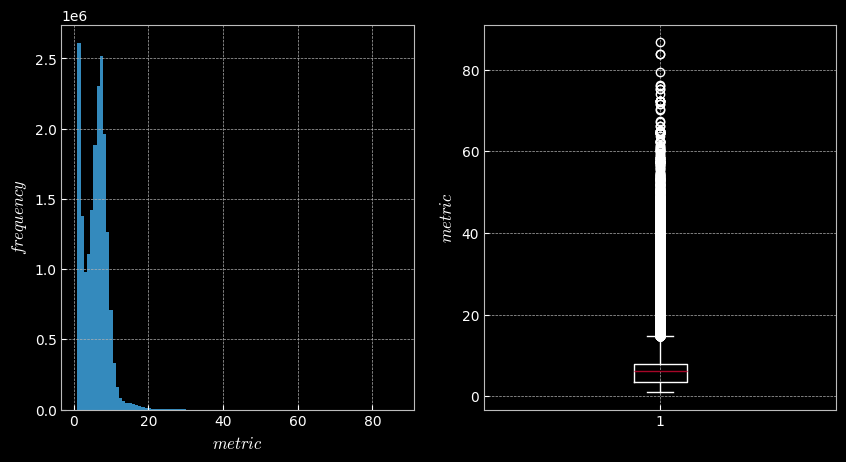

In [ ]:
display_token_stats(lbl_tok_tfidf)

In [ ]:
valid_toks = sparse_threshold_mask(lbl_tok_tfidf, min_val=7)
valid_toks[:, 101] = valid_toks[:, 102] = 1

In [ ]:
input_ids,mask = prune_tokens(block.train.dset.lbl_info['input_ids'],block.train.dset.lbl_info['attention_mask'],valid_toks)
block.train.dset.lbl_info['input_ids'], block.train.dset.lbl_info['attention_mask'] = input_ids, mask
block.test.dset.lbl_info['input_ids'], block.test.dset.lbl_info['attention_mask'] = input_ids, mask

  0%|          | 0/312330 [00:00<?, ?it/s]

### `trie` pruning

In [ ]:
block = TriePruneInputIdsTfm.apply(block, 'train.dset.data.lbl_info')

  0%|          | 0/1305265 [00:00<?, ?it/s]

In [ ]:
block.train.dset.data.lbl_info['input_ids'] = block.train.dset.data.lbl_info['input_ids_prn_tre']
block.train.dset.data.lbl_info['attention_mask'] = block.train.dset.data.lbl_info['attention_mask_prn_tre']

block.test.dset.data.lbl_info['input_ids'] = block.train.dset.data.lbl_info['input_ids_prn_tre']
block.test.dset.data.lbl_info['attention_mask'] = block.train.dset.data.lbl_info['attention_mask_prn_tre']

In [ ]:
tok_idf = get_tok_idf(block.train.dset, field='lbl2data_input_ids', n_cols=30522)

  0%|          | 0/692389 [00:00<?, ?it/s]

Text(0, 0.5, '$idf$')

<Figure size 700x500 with 0 Axes>

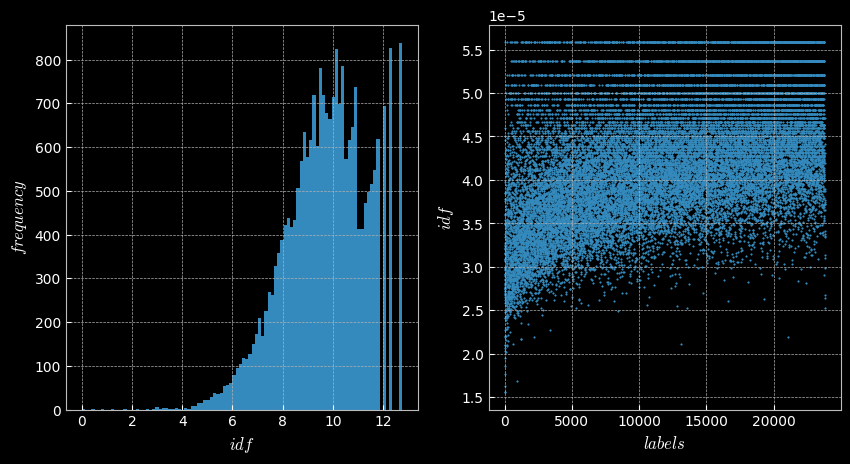

In [ ]:
plt.figure(figsize=(7,5))
fig, ax = plt.subplots(1, 2, figsize=(10,5))

idx = torch.where(tok_idf < 13)[0]
o = ax[0].hist(tok_idf[idx], bins=100)
ax[0].set_xlabel(r'$idf$'); ax[0].set_ylabel(r'$frequency$')

ax[1].scatter(torch.arange(len(idx)), F.softmax(tok_idf[idx]/10, dim=0), s=1)
ax[1].set_xlabel(r'$labels$'); ax[1].set_ylabel(r'$idf$')

In [ ]:
tok_idf = torch.where(tok_idf < 13, tok_idf, 1.0)

## Training

In [ ]:
#| export
args = XCLearningArguments(
    output_dir='/home/scai/phd/aiz218323/scratch/outputs/20-nar-training-pipeline-for-distilbert-2-1',
    logging_first_step=True,
    per_device_train_batch_size=800,
    per_device_eval_batch_size=800,
    representation_num_beams=200,
    representation_accumulation_steps=100,
    save_strategy="steps",
    evaluation_strategy='steps',
    eval_steps=2000,
    save_steps=2000,
    save_total_limit=5,
    num_train_epochs=100,
    adam_epsilon=1e-8,
    warmup_steps=0,
    weight_decay=0.1,
    learning_rate=2e-4,
    generation_num_beams=10,
    generation_length_penalty=1.5,
    predict_with_generation=True,
    label_names=['lbl2data_idx'],
    target_indices_key='plbl2data_idx',
    target_pointer_key='plbl2data_data2ptr',
)

In [ ]:
test_dset = block.test.dset.sample(n=2000, seed=50)
metric = PrecRecl(block.n_lbl, test_dset.data.data_lbl_filterer, prop=block.train.dset.data.data_lbl,
                  pk=10, rk=200, rep_pk=[1, 3, 5, 10], rep_rk=[10, 100, 200])

In [ ]:
model = DBT007.from_pretrained('distilbert-base-uncased', tn_targ=10_000, ig_tok=0, #vocab_weights=tok_idf,
                               reduction='mean')

In [ ]:
trie = XCTrie.from_block(block)

In [ ]:
learn = XCLearner(
    model=model, 
    args=args,
    trie=trie,
    train_dataset=block.train.dset,
    eval_dataset=test_dset,
    data_collator=block.collator,
    compute_metrics=metric,
)

In [ ]:
learn.train()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


node-0:2098748:2098748 [0] NCCL INFO Bootstrap : Using eth0:10.13.32.225<0>
node-0:2098748:2098748 [0] NCCL INFO NET/Plugin : Plugin load (librccl-net.so) returned 2 : librccl-net.so: cannot open shared object file: No such file or directory
node-0:2098748:2098748 [0] NCCL INFO NET/Plugin : No plugin found, using internal implementation
node-0:2098748:2098748 [0] NCCL INFO Kernel version: 5.15.0-1042-azure
RCCL version 2.17.1+hip5.7 HEAD:cbbb3d8+

node-0:2098748:2099806 [0] /long_pathname_so_that_rpms_can_package_the_debug_info/src/extlibs/rccl/build/hipify/src/misc/ibvwrap.cc:222 NCCL WARN Call to ibv_open_device failed

node-0:2098748:2099806 [0] /long_pathname_so_that_rpms_can_package_the_debug_info/src/extlibs/rccl/build/hipify/src/transport/net_ib.cc:199 NCCL WARN NET/IB : Unable to open device mlx5_0

node-0:2098748:2099806 [0] /long_pathname_so_that_rpms_can_package_the_debug_info/src/extlibs/rccl/build/hipify/src/misc/ibvwrap.cc:222 NCCL WARN Call to ibv_open_device failed

nod

node-0:2098748:2099807 [1] NCCL INFO Trees [0] -1/-1/-1->1->0 [1] -1/-1/-1->1->0 [2] -1/-1/-1->1->0 [3] 0/-1/-1->1->-1 [4] 0/-1/-1->1->-1 [5] 0/-1/-1->1->-1 [6] -1/-1/-1->1->0 [7] -1/-1/-1->1->0 [8] -1/-1/-1->1->0 [9] 0/-1/-1->1->-1 [10] 0/-1/-1->1->-1 [11] 0/-1/-1->1->-1 [12] -1/-1/-1->1->0 [13] -1/-1/-1->1->0 [14] -1/-1/-1->1->0 [15] 0/-1/-1->1->-1 [16] 0/-1/-1->1->-1 [17] 0/-1/-1->1->-1 [18] -1/-1/-1->1->0 [19] -1/-1/-1->1->0 [20] -1/-1/-1->1->0 [21] 0/-1/-1->1->-1 [22] 0/-1/-1->1->-1 [23] 0/-1/-1->1->-1 comm 0x1935ef10 nRanks 02 busId 400000
node-0:2098748:2099807 [1] NCCL INFO P2P Chunksize set to 524288
node-0:2098748:2099806 [0] NCCL INFO Ring 10 : 1 -> 0 -> 1 comm 0x1930edf0 nRanks 02 busId 300000
node-0:2098748:2099806 [0] NCCL INFO Ring 11 : 1 -> 0 -> 1 comm 0x1930edf0 nRanks 02 busId 300000
node-0:2098748:2099806 [0] NCCL INFO Ring 12 : 1 -> 0 -> 1 comm 0x1930edf0 nRanks 02 busId 300000
node-0:2098748:2099806 [0] NCCL INFO Ring 13 : 1 -> 0 -> 1 comm 0x1930edf0 nRanks 02 busI

/opt/conda/envs/ptca/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/envs/ptca/lib/python3.9/site-packages/transformers/utils/import_utils.py:521: FutureWarning: `is_torch_tpu_available` is deprecated and will be removed in 4.41.0. Please use the `is_torch_xla_available` instead.
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,P@1,P@10,P@3,P@5,N@1,N@10,N@3,N@5,Psp@1,Psp@10,Psp@3,Psp@5,Psn@1,Psn@10,Psn@3,Psn@5,R@200,R@10,R@100
500,3.616700,3.577754,0.020000,0.020000,0.030000,0.026000,0.020000,0.046378,0.034400,0.039914,0.024121,0.061009,0.041833,0.051078,0.024121,0.038693,0.031029,0.036241,0.071841,0.069841,0.071841
1000,3.047000,3.490322,0.020000,0.022000,0.030000,0.026000,0.020000,0.050156,0.033858,0.041597,0.024121,0.073980,0.041470,0.049367,0.024121,0.041978,0.030314,0.035202,0.078984,0.076984,0.078984
1500,2.938000,3.461247,0.010000,0.021000,0.020000,0.022000,0.010000,0.043711,0.020922,0.031162,0.012061,0.067987,0.025578,0.042010,0.012061,0.035817,0.017585,0.026014,0.078873,0.076873,0.078873
2000,2.862600,3.414996,0.020000,0.026000,0.023333,0.022000,0.020000,0.056172,0.027158,0.035937,0.015168,0.076384,0.030949,0.036378,0.015168,0.041403,0.021431,0.025987,0.099159,0.099159,0.099159
2500,2.806600,3.403909,0.020000,0.029000,0.030000,0.030000,0.020000,0.061813,0.033775,0.045677,0.015168,0.082803,0.031748,0.047807,0.015168,0.043842,0.021956,0.031525,0.109159,0.099159,0.109159
3000,2.760300,3.384682,0.020000,0.029000,0.033333,0.028000,0.020000,0.061742,0.037465,0.042541,0.015168,0.082611,0.032954,0.046235,0.015168,0.043698,0.022872,0.030494,0.104159,0.104159,0.104159


/opt/conda/envs/ptca/lib/python3.9/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/opt/conda/envs/ptca/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/envs/ptca/lib/python3.9/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/opt/conda/envs/ptca/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dim

### `Inference`

In [ ]:
#| export
output_dir = f"/home/scai/phd/aiz218323/scratch/outputs/{os.path.basename(args.output_dir)}"
mname = f'{output_dir}/{os.path.basename(get_best_model(output_dir))}'

In [ ]:
#| export
metric = PrecRecl(block.n_lbl, block.test.data_lbl_filterer, prop=block.train.dset.data.data_lbl,
                  pk=10, rk=200, rep_pk=[1, 3, 5, 10], rep_rk=[10, 100, 200])

In [ ]:
#| export
model = DBT007.from_pretrained(mname, tn_targ=10_000, ig_tok=0, #vocab_weights=tok_idf,
                               reduction='mean')

In [ ]:
#| export
trie = XCTrie.from_block(block)

  0%|          | 0/312330 [00:00<?, ?it/s]

In [ ]:
#| export
learn = XCLearner(
    model=model, 
    args=args,
    trie=trie,
    train_dataset=block.train.dset,
    eval_dataset=block.test.dset,
    data_collator=block.collator,
    compute_metrics=metric,
)

/scratch/scai/phd/aiz218323/anaconda3/envs/xc_nlg/lib/python3.9/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [ ]:
#| export
o = learn.predict(block.test.dset)

/scratch/scai/phd/aiz218323/anaconda3/envs/xc_nlg/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


/scratch/scai/phd/aiz218323/anaconda3/envs/xc_nlg/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [ ]:
display_metric(o.metrics)

,P@1,P@3,P@5,P@10,N@1,N@3,N@5,N@10,PSP@1,PSP@3,PSP@5,PSP@10,PSN@1,PSN@3,PSN@5,PSN@10,R@10,R@100,R@200,loss,runtime,samples_per_second,steps_per_second
0,15.4145,9.314,6.8614,4.2635,15.4145,14.5086,14.922,15.8464,10.0655,9.9482,10.5302,11.9141,10.0655,10.6089,11.2737,12.1878,18.278,18.3722,18.3722,7.1186,3701.2211,47.961,0.03


In [ ]:
#| export
pred_dir = f"{mname}/predictions/"
os.makedirs(pred_dir, exist_ok=True)

with open(f'{pred_dir}/test_predictions.pkl', 'wb') as file: 
    pickle.dump(o, file)

In [ ]:
#| export
print(o.metrics)